In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
from numpy import concatenate
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk990_6ay.xlsx'
data = pd.read_excel(path, date_parser=[0])
# İlk 5 Satır
data.head()

DATE_TIME  MAXIMUM_SPEED  MINIMUM_SPEED  AVERAGE_SPEED  \
0 2022-01-01 00:00:00            133              1             60   
1 2022-01-01 01:00:00            133              8             63   
2 2022-01-01 02:00:00            139              7             69   
3 2022-01-01 03:00:00            145              3             61   
4 2022-01-01 04:00:00            148              6             73   

   NUMBER_OF_VEHICLES  
0                 149  
1                 130  
2                 101  
3                  90  
4                  55

In [3]:

#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M')
#İndex'e Alınması
data.index = data.DATE_TIME

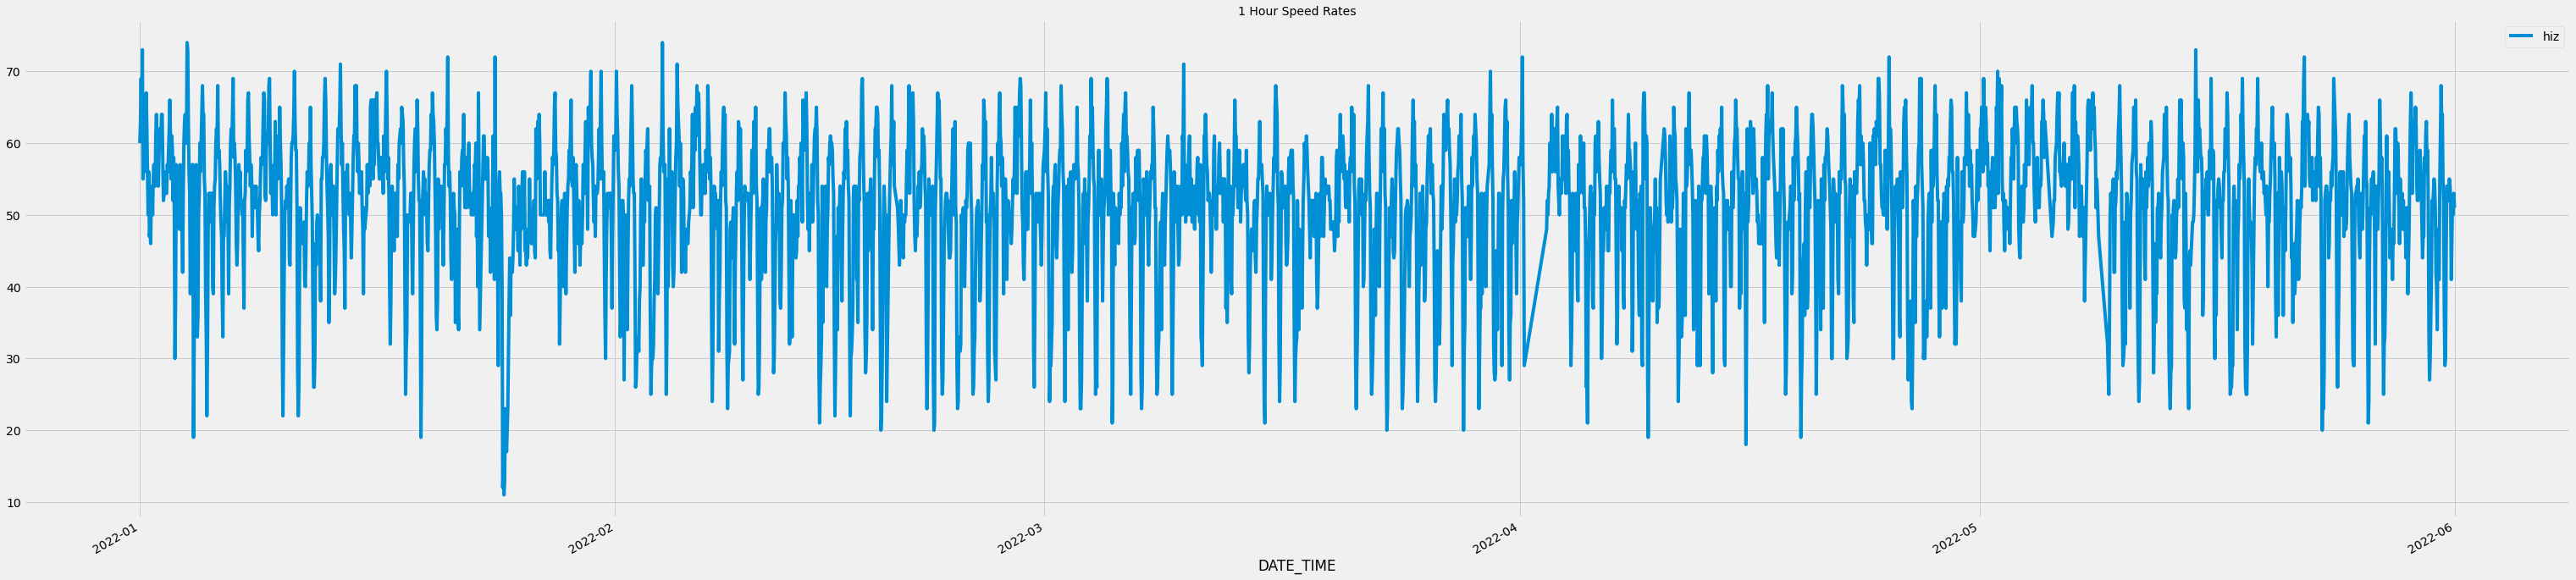

In [4]:
fig = plt.figure(figsize=(48,12))
data.AVERAGE_SPEED.plot(label='hiz')
plt.legend(loc='best')
plt.title('1 Hour Speed Rates', fontsize=14)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Veri Seti Sayıları (training set, test set): " + str((len(train), len(test))))

Veri Seti Sayıları (training set, test set): (2122, 1415)


In [8]:
def create_datasetMultiSteps(dataset, n_steps_out, window_size):
        dataX, dataY = [], []
        tot = window_size + n_steps_out - 1
        for i in range(int((len(dataset) - tot))):
                start_a = i
                end_a = start_a + window_size
                start_b = end_a
                end_b = end_a + n_steps_out
                a = dataset[start_a:end_a, 0]
                b = dataset[start_b:end_b, 0]
                dataX.append(a)
                dataY.append(b)
        return np.array(dataX), np.array(dataY)

In [9]:
# Verisetlerimizi Oluşturalım
window_size = 6
n_steps_out = 3
train_X, train_Y = create_datasetMultiSteps(train,n_steps_out, window_size)
test_X, test_Y = create_datasetMultiSteps(test,n_steps_out, window_size)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(2114, 6)


In [10]:
def sigmoid_act(x, der=False):
   import numpy as np

   if (der == True):  # Turev sigmoid
      f = 1 / (1 + np.exp(- x)) * (1 - 1 / (1 + np.exp(- x)))

   else:  # sigmoid
      f = 1 / (1 + np.exp(- x))

   return f

def tanh_act(x, der=False):
   import numpy as np

   if (der == True):  # Turev tanh
      f = 1 - np.square(((np.exp(x)) - (np.exp(-x))) / ((np.exp(x)) + (np.exp(-x))))
   else:
      f = ((np.exp(x)) - (np.exp(-x))) / ((np.exp(x)) + (np.exp(-x)))

   return f

def Lineer_act(x, der=False):
   import numpy as np

   if (der == True):  # the derivative of the ReLU is the Heaviside Theta
      f = 1
   else:
      f = x

   return f


In [11]:

m = window_size    # Gizli Katman Giris neron sayisi
n = 6    # Gizli Katman Durum neron sayisi
q = n_steps_out    # Cikis Katmani neron sayisi

eta = 2 / 100        # Learning rate
alpha = 9 / 100      # Momentum

#X1 = np.array([0.05,0.025,0.025,0.0025,0.025])        # X1 : x(k-1) baslangic degerleri 0 aliyoruz
X1 = 0.25 * np.random.normal(0, np.sqrt(0.01), n)

Wu2 = np.zeros((n, m))              # Wu2 : Wu(k-2) momentum icin
Wu1 = 0.25 * np.random.randn(n, m)  # Wu1 : Wu(k-1)  Gizli Katman Giris Agirlik Degerleri

Wx2 = np.zeros((n, n))              # Wx2 : Wx(k-2) momentum icin
Wx1 = 0.25 * np.random.randn(n, n)  # Wx1 : Wx(k-1) Gizli Katman Durum Agirlik Degerleri
b1 = 0.25 * np.random.randn(n)

Wy2 = np.zeros((q, n))              # Wy2 : Wy(k-2) momentum icin
Wy1 = 0.25 * np.random.randn(q, n)  # Wy1 : Wy(k-1) Cikis Katmani Agirlik Degerleri
bOut = 0.25 * np.random.randn(q)

E_ani_max = []
E_ort = []
epoch = 200                      # Iterasyon Sayisi


l= 199


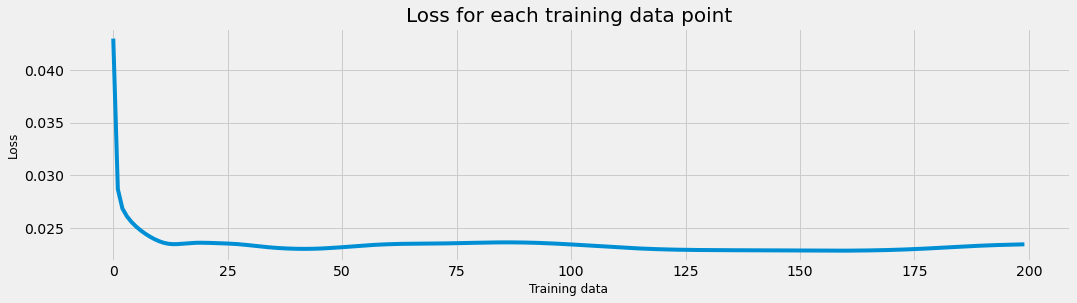

In [12]:
for l in range(epoch):
    E_ani = []
   
    for k in range(np.size(train_X, 0)):
     
      # 1: Egitim Veri Seti Girisi
      
     u = train_X[k]

     # 2: Feed forward
    
     v = np.dot(Wu1, u) + np.dot(Wx1, X1) + b1    
     X1 = tanh_act(v)                 # 1. Katman Cikisi
     y = np.dot(Wy1, X1) + bOut       # Cikis Katmani Cikisi    
     e = train_Y[k] - y
 
    
     # 3: Gradient descent
    
     Wu = Wu1 + (eta * np.dot((np.dot( Wy1.T , e.reshape(q, 1) ) * (tanh_act(v, der=True)).reshape(n,1)) , u.reshape(1, m))) + alpha * (Wu1 - Wu2)
     Wy = Wy1 + (eta * np.dot( e.reshape(q,1) , X1.reshape(1,n))) + alpha * (Wy1 - Wy2)
     Wx = Wx1 + (eta * np.dot((np.dot( Wy1.T , e.reshape(q, 1) ) * (tanh_act(v, der=True)).reshape(n,1)) , X1.reshape(1,n))) + alpha * (Wx1 - Wx2)
    

     Wu2 = Wu1
     Wu1 = Wu
     Wy2 = Wy1
     Wy1 = Wy
     Wx2 = Wx1
     Wx1 = Wx
    
     # 4. loss function Hesaplama
    
     E_ani.append((1 / 2) * np.dot(e.T, e) )

    E_ort.append((1 / np.size(train_X, 0)) * sum(E_ani))
    E_ani_max.append(max(E_ani))
    if l >= 21:
      if abs((E_ort[l - 1]) - (E_ort[l])) <= 0.0000000001 or (E_ort[l - 20]) - (E_ort[l]) <  -0.005  :
          print("E_ort_degisim=", (E_ort[l - 20]) - (E_ort[l]))
          break
#print("E_ort=",E_ort)
print("l=",l)

# 5. Her Iterasyon icin hatayi cizdiriyoruz

plt.figure(figsize=(16, 4))
plt.plot(E_ort)
plt.title('Loss for each training data point', fontsize=20)
plt.xlabel('Training data', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()


In [13]:
E_ani_tr = []
E_ort_tr = []
pred_train_Y  = []

# 6. Train Veri Seti Loss hesaplama


for m in range(np.size(train_X, 0)):

    x_tr = train_X[m]   
    v_tr = np.dot(Wu1, x_tr) + np.dot(Wx1, X1) + b1
    X1 = tanh_act(v_tr)                 # 1. Katman Cikisi
    y_tr = np.dot(Wy1, X1) + bOut     # Cikis Katmani Cikisi
    e_tr = train_Y[m] - y_tr    
    pred_train_Y.append(y_tr)
    
   

In [14]:
E_ani_t = []
E_ort_t = []
pred_test_Y  = []

# 7. Test Veri Seti Loss Hesaplama


for m in range(np.size(test_X, 0)):
    
    x_t = test_X[m]   
    v_t = np.dot(Wu1, x_t) + np.dot(Wx1, X1) + b1
    X1 = tanh_act(v_t)                 # 1. Katman Cikisi
    y_t = np.dot(Wy1, X1) + bOut     # Cikis Katmani Cikisi
    e_t = test_Y[m] - y_t    
    pred_test_Y.append(y_t)
    
    

In [15]:
  # Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
pred_train_Y = concatenate((train_X[:, -window_size:], pred_train_Y), axis=1)
pred_train_Y = scaler.inverse_transform(pred_train_Y)
pred_train_Y = pred_train_Y[:,-n_steps_out:]

# invert scaling for actual
train_Y = concatenate((train_X[:, -window_size:], train_Y), axis=1)
train_Y = scaler.inverse_transform(train_Y)
train_Y = train_Y[:,-n_steps_out:]


In [16]:
# invert scaling for forecast
pred_test_Y = concatenate(( test_X[:, -window_size:], pred_test_Y), axis=1)
pred_test_Y = scaler.inverse_transform(pred_test_Y)
pred_test_Y = pred_test_Y[:,-n_steps_out:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), n_steps))
test_Y = concatenate((test_X[:, -window_size:], test_Y), axis=1)
test_Y = scaler.inverse_transform(test_Y)
test_Y = test_Y[:,-n_steps_out:]

In [17]:
score_tr = math.sqrt(mean_squared_error(train_Y, pred_train_Y))
print("Train data score: %.2f RMSE" % score_tr)

score_t = math.sqrt(mean_squared_error(test_Y, pred_test_Y))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 9.13 RMSE
Test data score: 9.84 RMSE


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_Y, pred_train_Y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_Y, pred_test_Y)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(test_Y[:,0], pred_test_Y[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(test_Y[:,1], pred_test_Y[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(test_Y[:,2], pred_test_Y[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)


Train data score: 15.58 MAPE
Test data score: 16.05 MAPE
Test t zamanı score: 12.42 MAPE
Test t+1 zamanı score: 16.86 MAPE
Test t+2 zamanı score: 18.87 MAPE


In [19]:
mdape_t = np.median((np.abs(np.subtract(train_Y, pred_train_Y)/ train_Y))) * 100
print("Train data score: %.2f MdAPE" % mdape_t)

mdape_t = np.median((np.abs(np.subtract(test_Y, pred_test_Y)/ test_Y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 11.59 MdAPE
Test data score: 12.61 MdAPE


In [20]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_Y,pred_train_Y)
print("Train data score: %.2f SMAPE" % error_smape_tr)
error_smape_t = smape(test_Y,pred_test_Y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 45.93 SMAPE
Test data score: 49.09 SMAPE


In [21]:
from sklearn.metrics import mean_absolute_error
e_tr = train_Y - pred_train_Y
scale = mean_absolute_error(train_Y[1:], train_Y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_Y - pred_test_Y
scale = mean_absolute_error(test_Y[1:], test_Y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 1.37 MASE
Test data score: 1.45 MASE


In [22]:
train_y=train_Y
pred_train_y=pred_train_Y
test_y=test_Y
pred_test_y=pred_test_Y

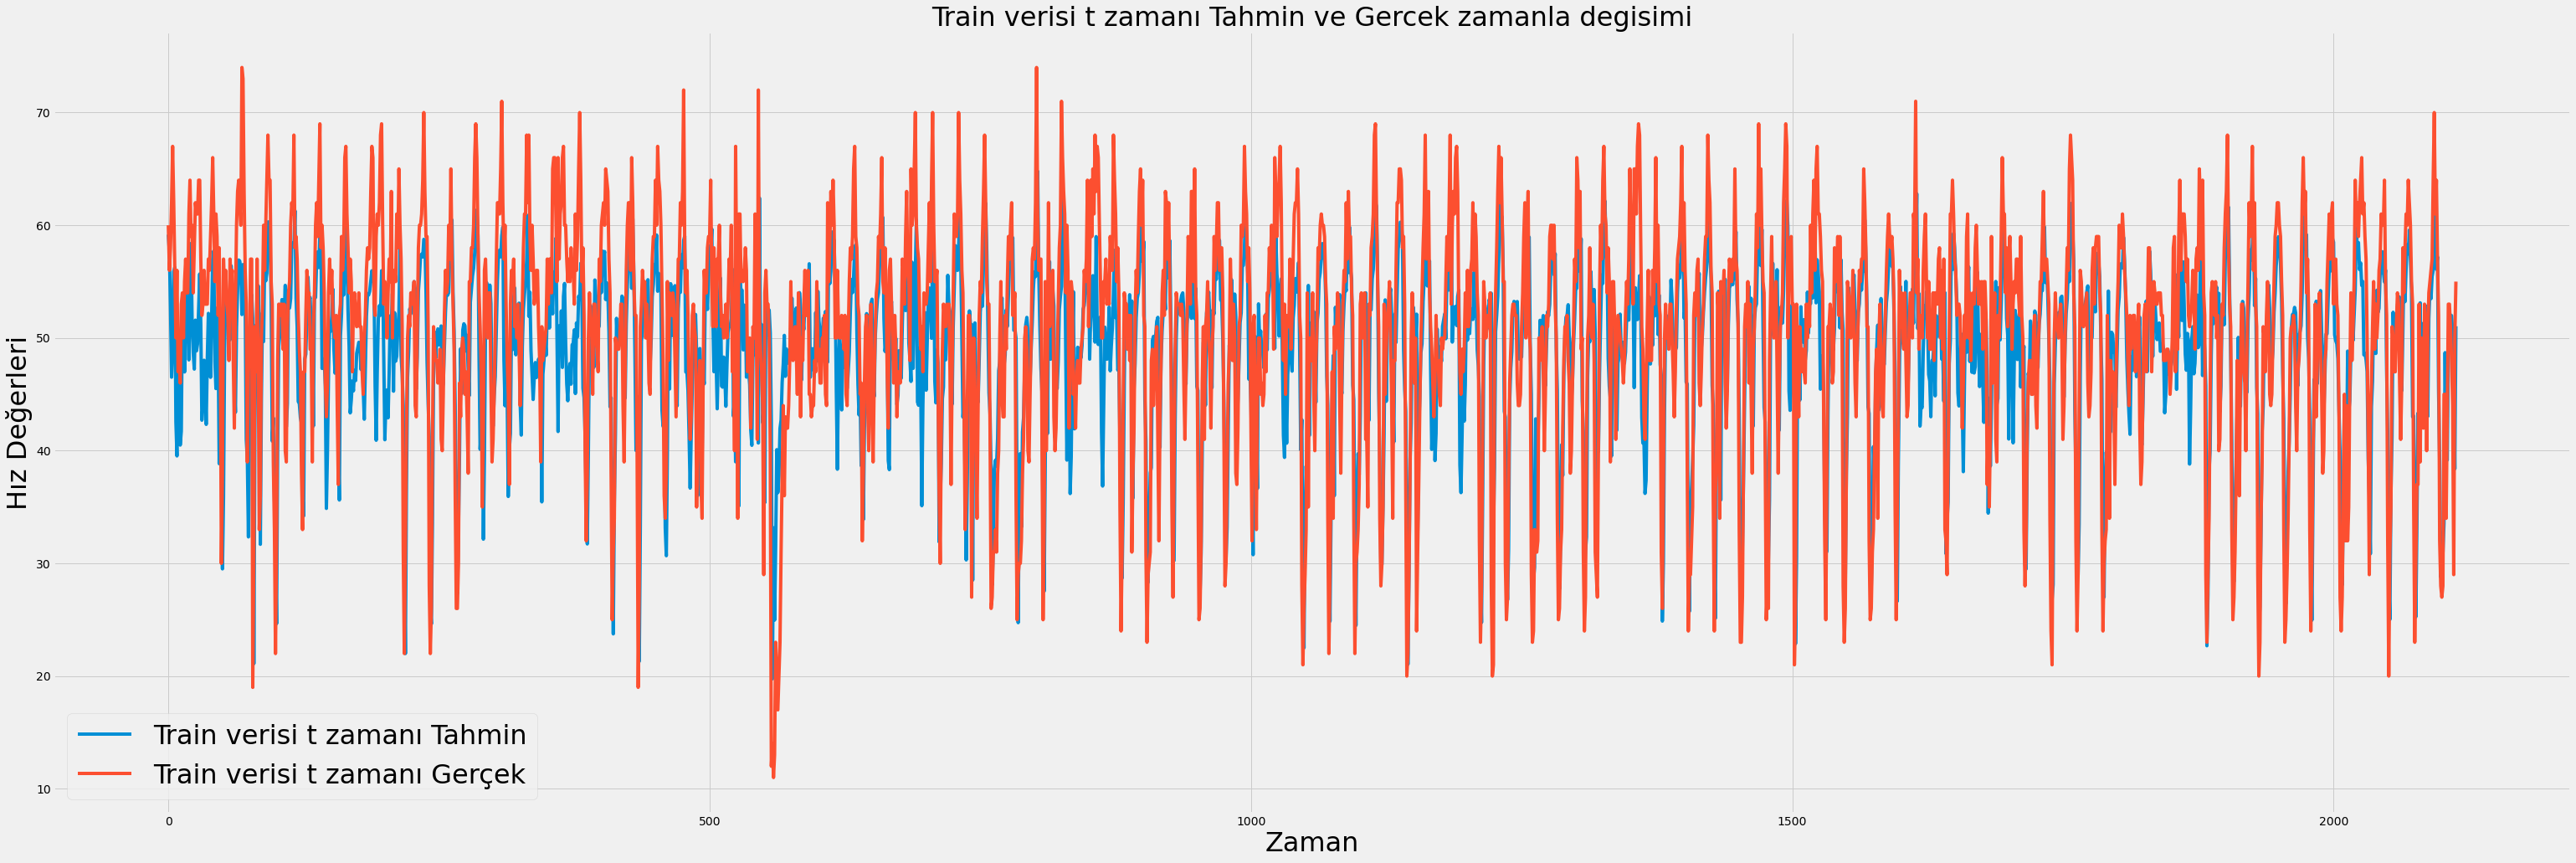

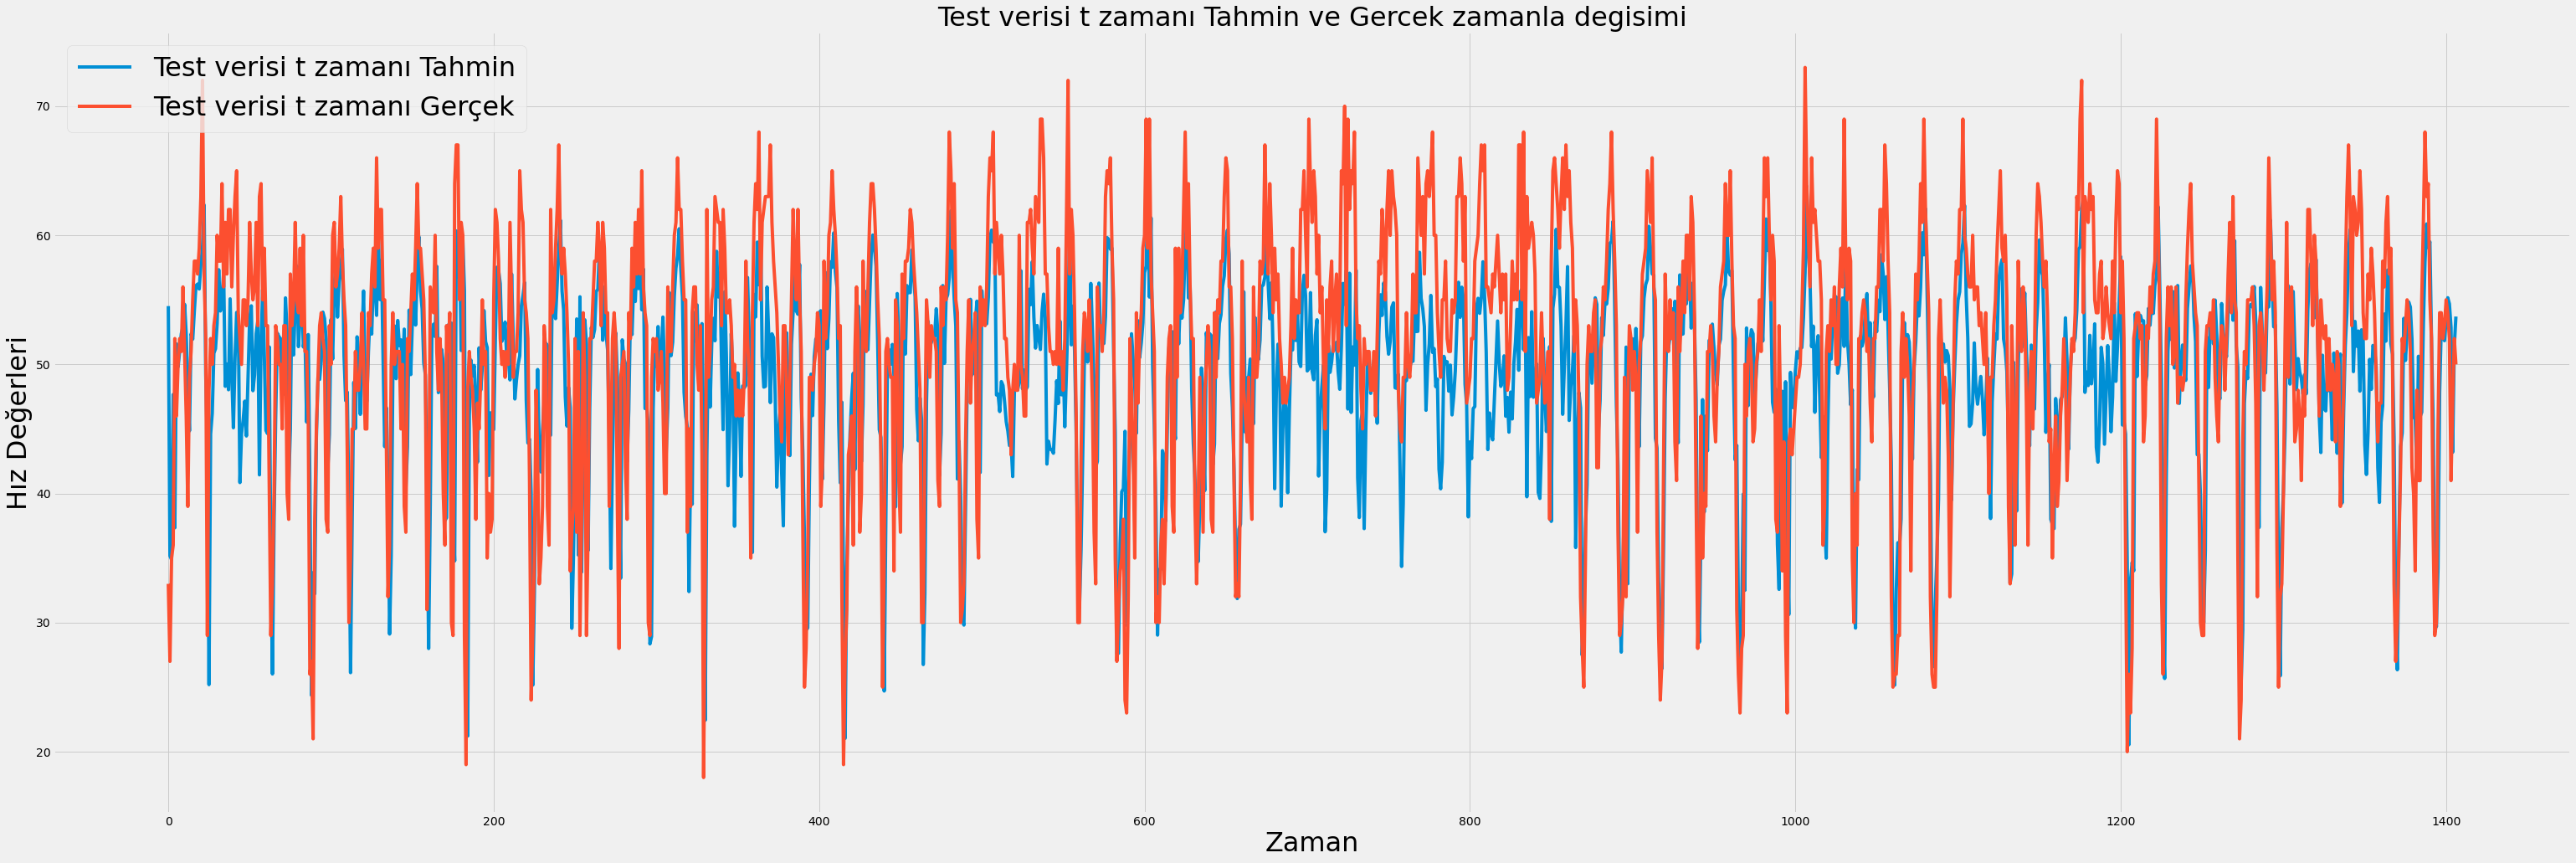

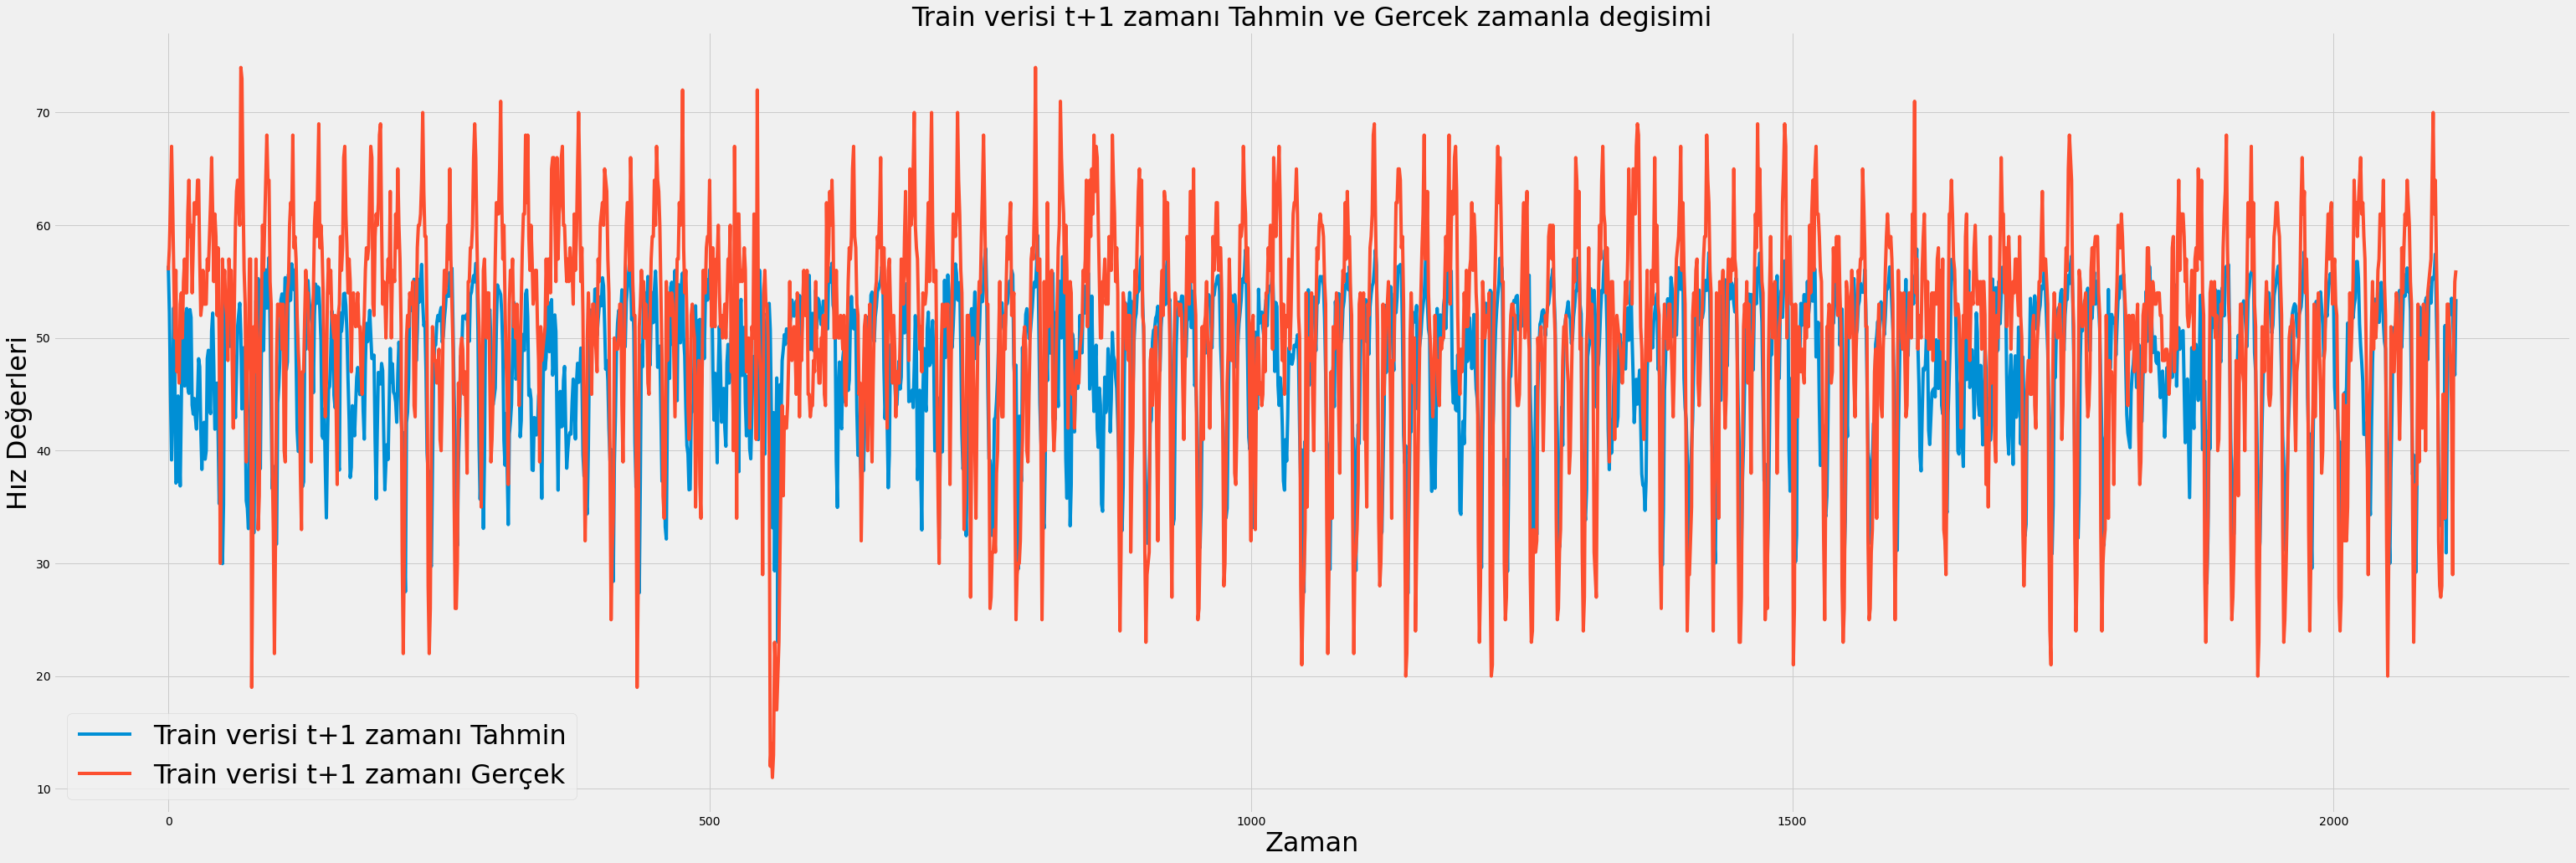

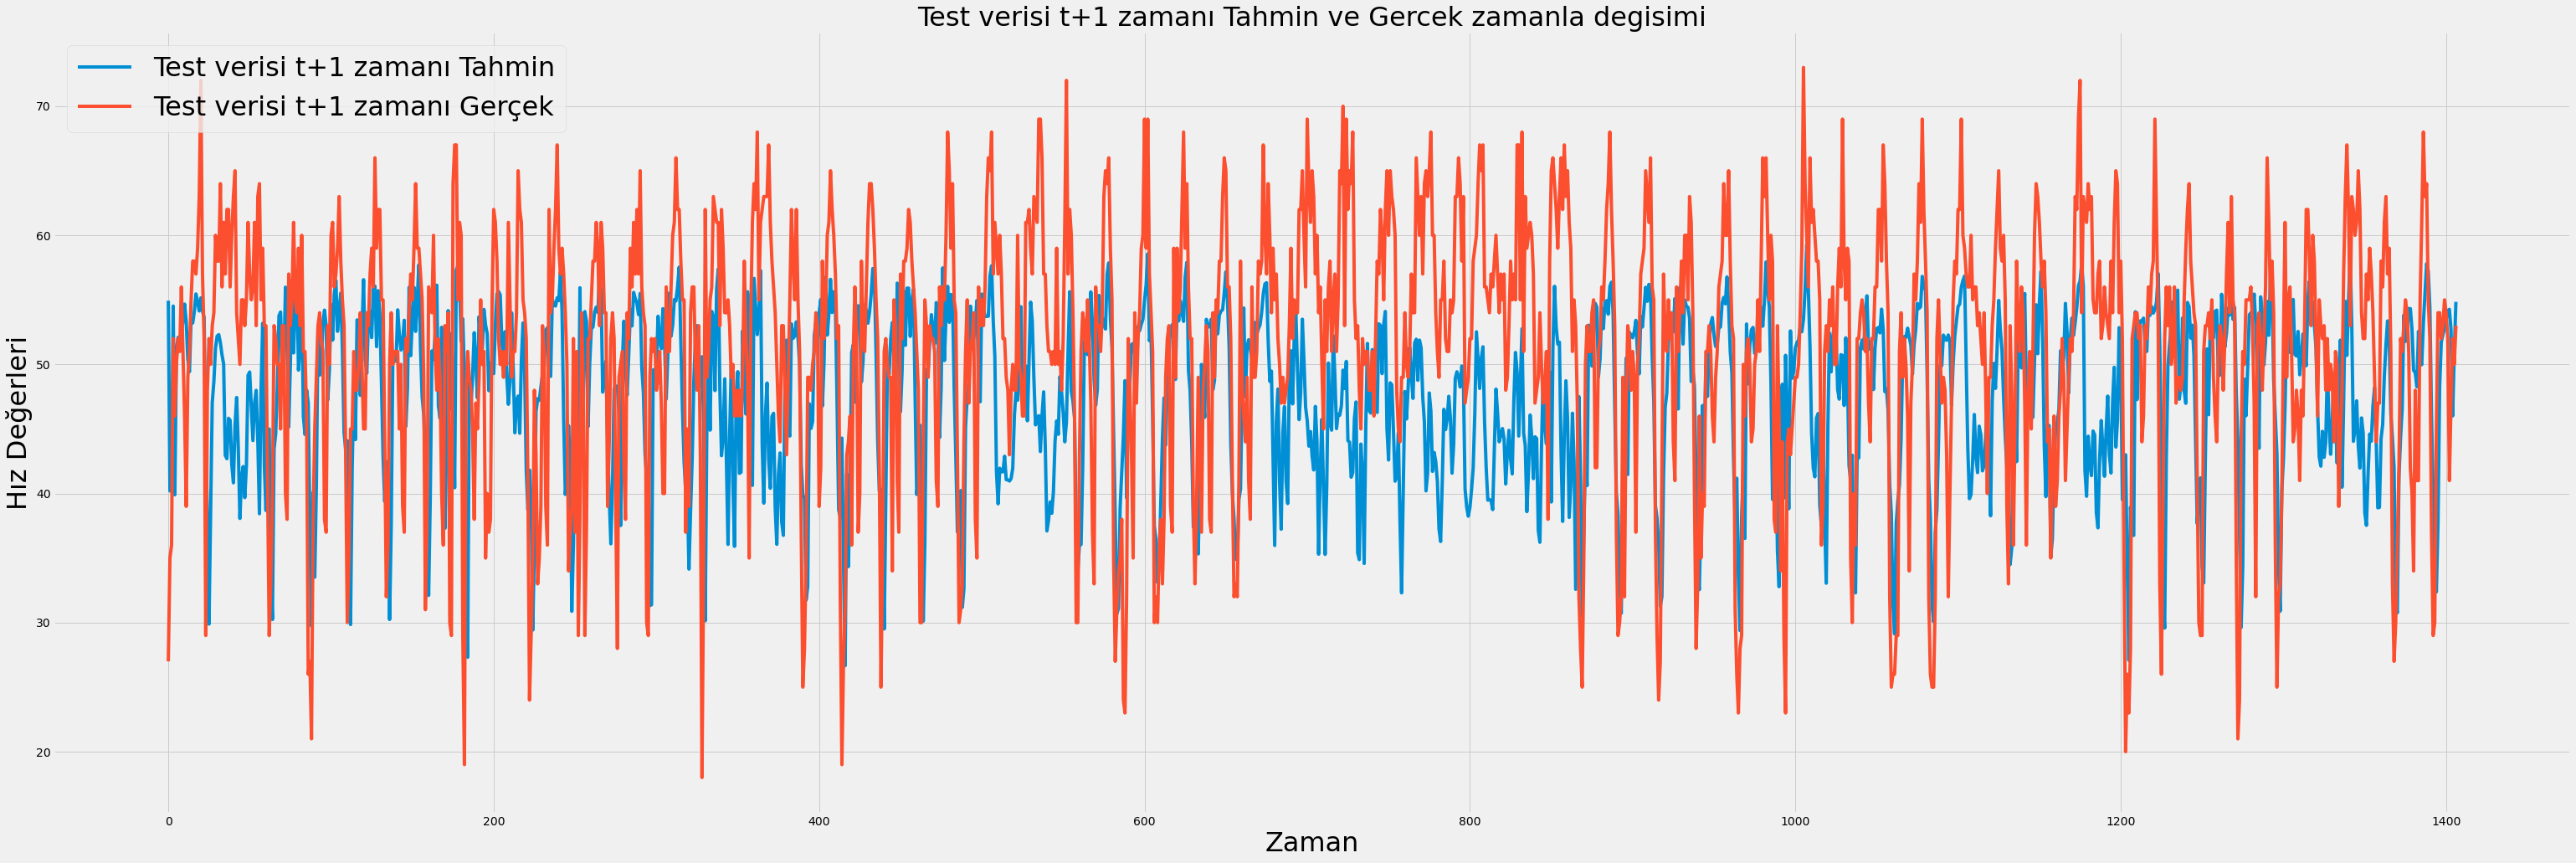

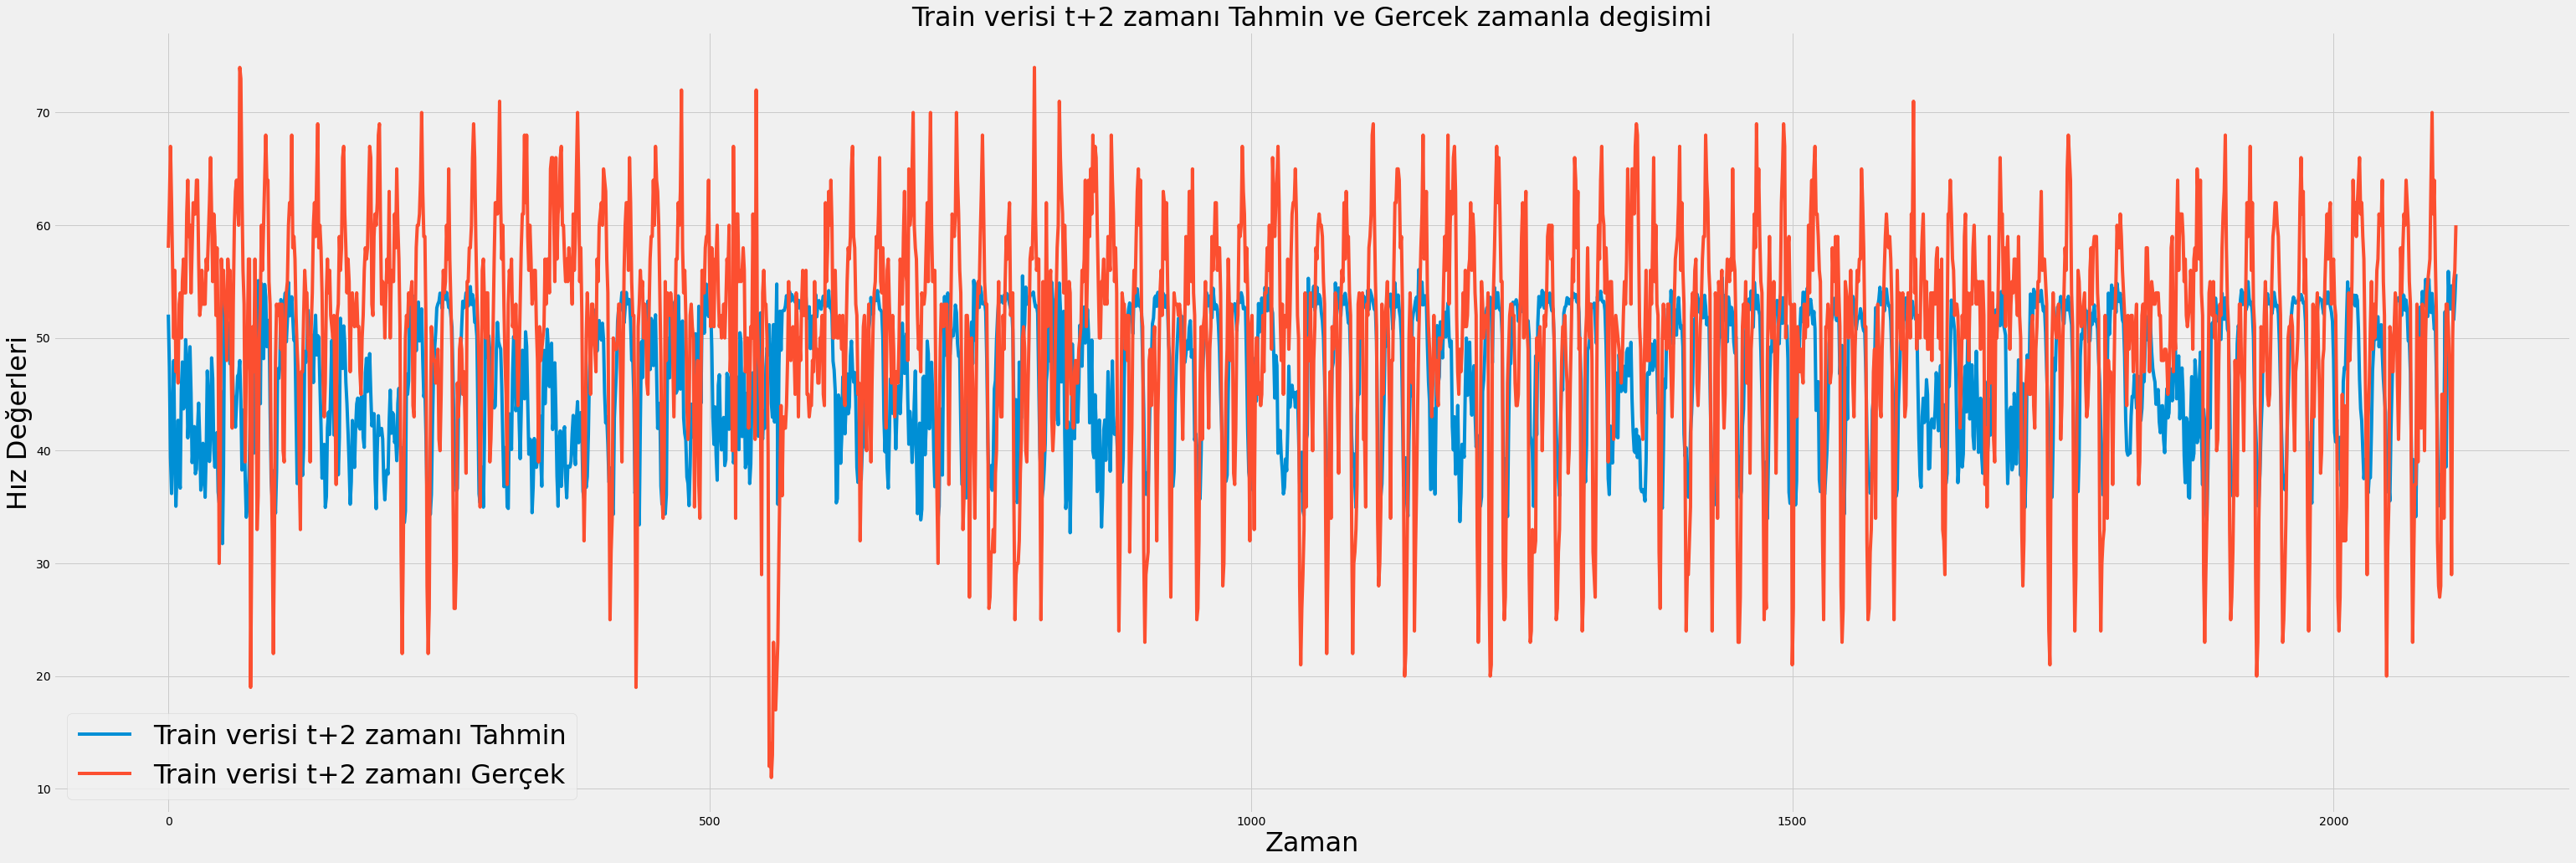

In [23]:
# 10. Test Veri Seti icin Ag sonucu ve verili cikislari cizdiriyoruz

train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')